In [ ]:
# Required initialization
!pip install transformers
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.4 MB/s eta 0:00:00


In [ ]:
#Required importations
from transformers import AutoTokenizer
import transformers
import torch

In [ ]:
#Initialization of the prompting pipeline as shown in the TinyLlama documentation
pipe = transformers.pipeline("text-generation", model="TinyLlama/TinyLlama-1.1B-Chat-v0.6", torch_dtype=torch.bfloat16, device_map="auto")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

In [ ]:
#Test messsage to check if the prompting pipeline produces an answer.
messages = [
     {
        "role": "system",
        "content": "You are an expert on online terms of service.",
    },
    {"role": "user", "content": "Is this clause fair to the user answering by yes or no : <CLAUSE>you agree that instagram is not responsible or liable for the conduct of any user</CLAUSE>"}]
prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
outputs = pipe(prompt, max_new_tokens=64, do_sample=True, temperature=0.1, top_k=50, top_p=0.95)
print(outputs[0]["generated_text"])

<|system|>
You are an expert on online terms of service.</s>
<|user|>
Is this clause fair to the user answering by yes or no : <CLAUSE>you agree that instagram is not responsible or liable for the conduct of any user</CLAUSE></s>
<|assistant|>
Yes, this clause is fair to the user answering by yes or no. It states that the user agrees that Instagram is not responsible or liable for the conduct of any user. This means that the user is acknowledging that they are responsible for their own actions and that Instagram is not responsible for any issues


# MANUAL PROMPTING


In [ ]:
#In this cell you should select the training dataset, with all the labels that we have created earlier in the semester
from google.colab import files

uploaded = files.upload()



Saving claudette_train_multi_label.csv to claudette_train_multi_label.csv


In [ ]:
import pandas as pd
#Read the csv dataset as a pandas dataframe
df = pd.read_csv('claudette_train_multi_label.csv')
#Print to check if this is the correct dataset
print(df)

      Index    Document   Labels  \
0         0     Mozilla       []   
1         1     Mozilla       []   
2         2     Mozilla  ['USE']   
3         3     Mozilla       []   
4         4     Mozilla       []   
...     ...         ...      ...   
8349  20297  Foursquare       []   
8350  20298  Foursquare       []   
8351  20299  Foursquare       []   
8352  20300  Foursquare       []   
8353  20301  Foursquare       []   

                                               Sentence  
0                websites & communications terms of use  
1     please read the terms of this entire document ...  
2     by accessing or signing up to receive communic...  
3     our websites include multiple domains such as ...  
4     you may also recognize our websites by nicknam...  
...                                                 ...  
8349  solely in respect of users located in the eea ...  
8350  where foursquare has provided you with a trans...  
8351  if there is any contradiction between w

In [ ]:
import ast
import random
from prettytable import PrettyTable
import matplotlib.pyplot as plt

#This function analyzes the answer to the prompt to classify it between fair and unfair
#The decision sequence is based on our analysis of a number of answers

def is_fair(string):
    lower_string = string.lower()  # Convert the string to lowercase for case-insensitive comparison

    if "is fair" in lower_string or "not unfair" in lower_string or "not considered to be unfair" in lower_string:
        return "Fair"
    elif "is unfair" in lower_string or "not fair" in lower_string:
      return "Unfair"
    else:
      return "NONE"

# Example usage:
test_string = "This clause is fair, yes."
result = is_fair(test_string)
print(result)

#This function takes the label column of a dataframe and return a list of the labels strings
#It assigns the label "No_label" to columns without a label
def clean_labels(str_label):
  if str_label=="[]":
    label=["No_label"]
  else:
    label=ast.literal_eval(str_label)
  return label

#Test
test_label_1="[]"
test_label_2="[\"use\",\"ter\"]"

print(clean_labels(test_label_1))
print(clean_labels(test_label_2))

#This function returns one string based on the labels for a given line
#If there is no label (or the PINC label which should be ignored) it returns a rule at random
#The definition of what is unfair for each rule come from the Claudette paper and the definitions of what is fair come from generated knowledge from GPT 3.5
def select_adaptative_rule(label):
  rules=""

  cr="<ContentRemoval><unfair> The provider can unilaterally modify or delete the user's content. The service provider may remove content in his full discretion</unfair><fair><ContentRemoval><fair> The service provider may remove content only under specific circumstances outlined in the terms agreed upon by both parties.</fair></ContentRemoval>"
  ch="<UnilateralChange><unfair> The provider can unilaterally amend or modify the terms of service or the service itself. </unfair><UnilateralChange><fair> The provider can amend or modify the terms of service only after providing advance notice and obtaining explicit consent from the user.</fair></UnilateralChange>"
  a="<Arbitration><unfair>The arbitration should (1) take place in a state other than the state of consumer’s residence and/or (2) be based not on law but on arbiter’s discretion.</unfair><fair>Requires or allow the parties to resolve their disputes through an arbitration process, before the case could go to court.</fair></Arbitration>"
  j="<Jurisdiction><unfair> Any judicial proceeding takes place away from the user's place of residence. </unfair><fair>Giving the consumers a right to bring disputes in their place of residence </fair></Jurisdiction>"
  law="<ChoiceOfLaw><unfair> The law governing the contract is not the law of the user's country of residence. </unfair><fair>Clauses defining the applicable law as the law of the consumer’s country of residence were marked as clearly fair</fair></ChoiceOfLaw>"
  ltd="<LimitationOfLiability><unfair> Clauses that limit the provider's duty to pay damages. Clause meant to reduce, limit, or exclude the liability of the service provider for physical injuries, intentional damages as well as in case of gross negligence.</unfair> <fair>Clauses that explicitly affirm non-excludable providers’ liabilities were marked as clearly fair. </fair></LimitationOfLiability>"
  ter="<UnilateralTermination><unfair> The provider has the right to unilaterally terminate the service or the contract. </unfair><fair> The provider may suspend or terminate the service or contract only under specific, predefined circumstances that are clearly outlined and agreed upon in the terms.</fair></UnilateralTermination>"
  use="<ContractByUsing><unfair> The consumer is bound by the terms of service by simply using the service. </unfair><fair> The consumer is bound by the terms of service only after explicit acknowledgment and acceptance of the terms.</fair></ContractByUsing>"


  if "A" in label:
    rules+=a
  elif "CR" in label:
    rules+=cr
  elif "CH" in label:
      rules += ch
  elif "J" in label:
      rules += j
  elif "LAW" in label:
      rules += law
  elif "LTD" in label:
      rules += ltd
  elif "TER" in label:
      rules += ter
  elif "USE" in label:
      rules += use
  else:
  # If no specific label is matched, return one rule at random
    rules = random.choice([a, ch, cr, j, law, ltd, ter, use])
  return rules

#This function returns a string containing unfair clauses taken from the validation dataset for each label
#If there is no label (or the PINC label which should be ignored), it returns an example at random
def adaptative_ex(label):

  cr=" we have the right , but not the obligation , in our sole discretion to edit , refuse to post , or remove any user content . "
  ch=" our company reserves the right to modify these terms at any time in accordance with this provision . "
  a=" by accepting these terms of service , you agree to be bound by this arbitration clause and class action waiver . "
  j=" you agree that any claim or dispute you may have against our company must be resolved exclusively by a court located in san francisco , california "
  law=" these terms and any action related thereto will be governed by the laws of the state of california without regard to its conflict of laws provisions. "
  ltd=" the foregoing limitations of liability shall apply to the fullest extent permitted by law in the applicable jurisdiction . "
  ter=" we reserve the right to modify or terminate the service or your access to the service for any reason , without notice , at any time , and without liability to you . "
  use=" by using or accessing the services ,  you agree to be bound by all the terms and conditions of this agreement . "

  ex=""
  if "A" in label:
    ex+=a
  elif "CR" in label:
    ex+=cr
  elif "CH" in label:
    ex += ch
  elif "J" in label:
    ex += j
  elif "LAW" in label:
      ex += law
  elif "LTD" in label:
      ex += ltd
  elif "TER" in label:
      ex += ter
  elif "USE" in label:
      ex += use
  else:
  # If no specific label is matched, return one rule at random
    ex = random.choice([a, ch, cr, j, law, ltd, ter, use])
  return ex




#This function enables the graphical display of the results on series of prompts.
def display_results(results, labels):
    total_counts = [result['Fair'] + result['Unfair'] for result in results]
    fair_normalized = [result['Fair'] / total_count if total_count != 0 else 0 for result, total_count in zip(results, total_counts)]
    unfair_normalized = [result['Unfair'] / total_count if total_count != 0 else 0 for result, total_count in zip(results, total_counts)]

    width = 0.35  # Width of the bars
    ind = range(len(labels))

    fig, ax = plt.subplots()
    fair_bars = ax.bar(ind, fair_normalized, width, label='Fair')
    unfair_bars = ax.bar(ind, unfair_normalized, width, bottom=fair_normalized, label='Unfair')

    ax.set_ylabel('Normalized Counts')
    ax.set_title('Normalized Fair and Unfair Counts for Each Label')
    ax.set_xticks(ind)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.show()




Fair
['No_label']
['use', 'ter']


In [ ]:
#The functions in this cell allows for the computation of the macro precision, recall and F1-score from a list with the labels name and a list of dictionnary
#storing the number of sentences classified as fair or unfair, each dictionnary in this list corresponding to a label in the label list

def compute_precision(results, labels):
    true_positives = 0
    false_positives = 0

    for result, label in zip(results, labels):
        if label != "No_label":
            true_positives += result["Unfair"]
        else:
            false_positives += result["Unfair"]



    if true_positives + false_positives == 0:
        precision = 0  # To handle the case where there are no Unfair predictions
    else:
        precision = true_positives / (true_positives + false_positives)

    return precision

def compute_recall(results, labels):
    true_positives = 0
    false_negatives = 0

    for result, label in zip(results, labels):
        if label != "No_label":
            true_positives += result["Unfair"]
            false_negatives += result["Fair"]


    if true_positives + false_negatives == 0:
        recall = 0  # To handle the case where there are no Unfair ground truth instances
    else:
        recall = true_positives / (true_positives + false_negatives)

    return recall

# Example usage:
LABELS = ["A", "CH", "CR", "J", "LAW", "LTD", "TER", "USE", "No_label","PINC"]
results = [{'Fair': 0, 'Unfair': 0}, {'Fair': 1, 'Unfair': 0}, {'Fair': 0, 'Unfair': 0},
           {'Fair': 0, 'Unfair': 1}, {'Fair': 0, 'Unfair': 0}, {'Fair': 0, 'Unfair': 0},
           {'Fair': 0, 'Unfair': 0}, {'Fair': 0, 'Unfair': 0}, {'Fair': 6, 'Unfair': 2},{'Fair': 0, 'Unfair': 0}]

precision_value = compute_precision(results, LABELS)
recall_value = compute_recall(results, LABELS)
print(f"Precision: {precision_value}")
print(f"Recall: {recall_value}")

def f1_score(recall, precision):
    if recall != 0 and precision != 0:
        return 2 * recall * precision / (recall + precision)
    return 0

f1_result = f1_score(recall_value, precision_value)
print(f"F1 Score: {f1_result}")

Precision: 0.3333333333333333
Recall: 0.5
F1 Score: 0.4


In [ ]:

import random
# Defining the function to select a number n of clauses with a random seed, it is also possible set the proportion of sentences chosen with a label
#This method avoids selecting the same sentence twice
def select_n_clauses(n, seed):
    random.seed(seed)  # Set the random seed for reproducibility

    proba_having_label=0.9 #If you want to reflect the true proportions of labelled sentences from our dataset, you should set this to 0.1

    already_chosen_empty =[]
    already_chosen_non_empty=[]

    sentences_list = []
    labels_list = []

    non_empty_labels_df = df[df['Labels'] != '[]']
    empty_labels_df = df[df['Labels'] == '[]']

    while len(sentences_list)<n:
        random_number = random.random()
        if random_number > proba_having_label:
            random_index = random.randint(0, len(empty_labels_df) - 1)
            if random_index not in already_chosen_empty:
              random_row = empty_labels_df.iloc[random_index]
              row_index = random_row['Index']
              label = clean_labels(random_row['Labels'])
              sentence = random_row['Sentence']
              already_chosen_empty.append(random_index)
        else:
            random_index = random.randint(0, len(non_empty_labels_df) - 1)
            if random_index not in already_chosen_non_empty :
              random_row = non_empty_labels_df.iloc[random_index]
              label = clean_labels(random_row['Labels'])
              sentence = random_row['Sentence']
              already_chosen_non_empty.append(random_index)

        sentences_list.append(sentence)
        labels_list.append(label)

    assert len(sentences_list) == len(labels_list)
    #print(already_chosen)
    return sentences_list, labels_list

# Test
#If you run this test several times, as long as you keep the same random seed and the same probability of having a label, you should get the same results
clauses,labels = select_n_clauses(5,42)
print(clauses)
print(labels)




["the company 's intellectual property policy is to -lrb- i -rrb- remove or disable access to material that the company believes in good faith , upon notice from an intellectual property owner or his or her agent , is infringing the intellectual property of a third party by being made available through the service ; and -lrb- ii -rrb- remove any user content uploaded to the service by `` repeat infringers . ''", 'the most recent version of this agreement will be posted on the services under settings and also on gotinder.com , and you should regularly check for the most recent version .', 'where we consider that such changes are reasonably material , we will -lrb- where reasonably practicable -rrb- notify you -lrb- via http://www.wechat.com , direct communication to you , on this page or the relevant page for the relevant additional terms or policy , or other means -rrb- , prior to such changes becoming effective .', 'you agree that we may take any such actions at any time .', 'by using

The clause is unfair to the customer in the sense that it allows the service provider to unilaterally modify or delete user content without the need for any prior notice or consent from the customer. This is because the clause allows the service provider to remove content without any prior
Yes, the clause in the Online Terms of Services is unfair to the customer because it allows the provider to unilaterally amend or modify the terms of service or the service itself, without obtaining prior written consent from the user. This means that the provider can change or modify any
To be sure that the clause is fair to the customer, we would need to ask the following questions: 1. Is the modification necessary? Is there a clear, compelling reason for the provider to change the terms of service or service itself? 2. Are the terms fair to the user?
To determine whether the clause is unfair to the customer, we can follow the following steps: 1. Review the clause: The first step is to review the c

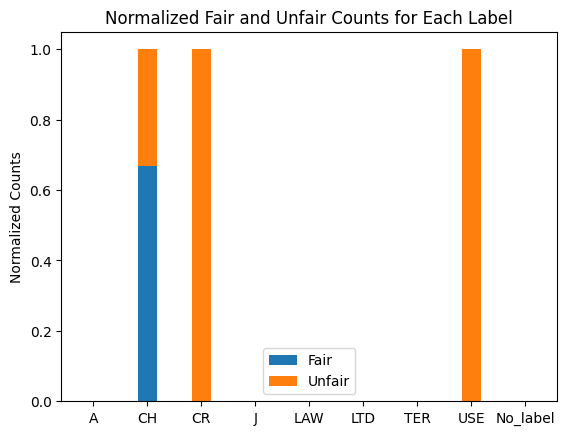

-----RECAP-----
Precision : 1.0
Recall : 0.6
F1-Score : 0.7499999999999999
-----RECAP-----
+----------+------+--------+-------+--------------------+
|  Label   | Fair | Unfair | Total |      Accuracy      |
+----------+------+--------+-------+--------------------+
|    A     |  0   |   0    |   0   |         0          |
|    CH    |  2   |   1    |   3   | 0.3333333333333333 |
|    CR    |  0   |   1    |   1   |        1.0         |
|    J     |  0   |   0    |   0   |         0          |
|   LAW    |  0   |   0    |   0   |         0          |
|   LTD    |  0   |   0    |   0   |         0          |
|   TER    |  0   |   0    |   0   |         0          |
|   USE    |  0   |   1    |   1   |        1.0         |
| No_label |  0   |   0    |   0   |         0          |
+----------+------+--------+-------+--------------------+


In [ ]:
#This cell runs the prompts cycles and displays the results

import random

#Number of iterations
n = 5
#Random seed for reproductability
seed=42

clauses_list,labels_list=select_n_clauses(n,seed)

LABELS=["A","CH","CR","J","LAW","LTD","TER","USE","No_label","PINC"]
stats=[{"Fair":0,"Unfair":0},{"Fair":0,"Unfair":0},{"Fair":0,"Unfair":0},{"Fair":0,"Unfair":0},{"Fair":0,"Unfair":0},{"Fair":0,"Unfair":0},{"Fair":0,"Unfair":0},{"Fair":0,"Unfair":0},{"Fair":0,"Unfair":0},{"Fair":0,"Unfair":0}]


for i in range(n):
  #print(f"Iteration {i+1} of {n}")
  label=labels_list[i]
  sentence=clauses_list[i]

  adaptative_rule=""
  adaptative_rule=select_adaptative_rule(label)
  adaptative_clause=adaptative_ex(label)
  #This part sends the prompts to the LLm and returns the result
  messages = [
    {
        "role": "system",
        "content": "You are an expert in the field of Online Terms of Services. ",
    },
    {"role": "user", "content":"<RULE>"+adaptative_rule+"<\RULE>The clause is : <CLAUSE>"+sentence+"<\CLAUSE>. <QUESTION>Is the clause unfair to the customer ? Among the answers Yes or No, the answer is : </QUESTION> Let's think step by step"}]
  prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
  outputs = pipe(prompt, max_new_tokens=128, do_sample=True, temperature=0.8, top_k=10, top_p=0.95)
  generated_text = outputs[0]["generated_text"]
  #print(generated_text)


  # Extract the first 50 words from the relevant the answer, to have readable results
  start_index = generated_text.find("<|assistant|>") + len("<|assistant|>")
  substring = generated_text[start_index:]
  first_50_words = ' '.join(substring.split()[:50])
  print(first_50_words)


  #Analyze the answer to check if it is marked as Fair
  test=is_fair(first_50_words)
  #print(test)
  if test != "NONE":
    for l in label:
      index = LABELS.index(l)
      stats[index][test]+=1

#The four following lines are here to merge the No_label and the PINC classes which should not be separated
stats[8]["Fair"]+=stats[9]["Fair"]
stats[8]["Unfair"]+=stats[9]["Unfair"]
stats = stats[:-1]
LABELS = LABELS[:-1]

#Finally, the following lines enable the computation and the display of our results using the prettyTable library

display_results(stats,LABELS)
p=compute_precision(stats,LABELS)
r=compute_recall(stats,LABELS)
f1=f1_score(r,p)
print("-----RECAP-----")
print(f"Precision : {p}")
print(f"Recall : {r}")
print(f"F1-Score : {f1}")
table = PrettyTable()
table.field_names = ["Label", "Fair", "Unfair", "Total", "Accuracy"]

for label, stat in zip(LABELS, stats):
    n_fair = stat['Fair']
    n_unfair = stat['Unfair']
    total = n_fair + n_unfair
    acc = 0

    if label != "No_label" and total != 0:
        acc = n_unfair / total
    elif label == "No_label" and total != 0:
        acc = n_fair / total

    # Add a row to the table
    table.add_row([label, n_fair, n_unfair, total, acc])

# Print the table
print("-----RECAP-----")
print(table)
